In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas
from sklearn import metrics
import urllib2
from scipy import stats
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns

In [2]:
tt = np.loadtxt('/Users/linan/Downloads/testadjr2allparameter_hsz5_raw.txt')

In [3]:
tt2 = np.loadtxt('/Users/linan/Downloads/testadjr2allparameter_hsz5_raw_rand.txt')

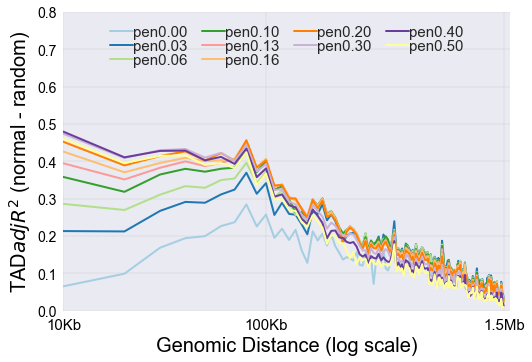

In [9]:
num_plots = 10
penlist = [0,0.03,0.06,0.1,0.13,0.16,0.2,0.3,0.4,0.5]

colormap = plt.cm.Paired
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

x = np.arange(10)
labels = []
for i in range(0, 0+num_plots):
    plt.plot(tt[i,0:150]-tt2[i,0:150],linewidth=2)
    labels.append(r'pen%1.2f' % (penlist[i]))

plt.legend(labels, ncol=4, loc='upper center', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True, fontsize=15)
plt.xscale('log')
plt.ylabel('TAD$adjR^2$ (normal - random)', {'color': 'k', 'fontsize': 20})
plt.xlabel('Genomic Distance (log scale)', {'color': 'k', 'fontsize': 20})
plt.yticks(color='k',size=14)
plt.xticks((1,10,150),('10Kb', '100Kb','1.5Mb'),color='k',size=15)
plt.ylim(0,0.8)
plt.xlim(0,160)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig("/Users/linan/Desktop/parameter_tadrsquared.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()


pen0.00 area = 0.170
pen0.03 area = 0.213
pen0.06 area = 0.217
pen0.10 area = 0.219
pen0.13 area = 0.217
pen0.16 area = 0.214
pen0.20 area = 0.210
pen0.30 area = 0.194
pen0.40 area = 0.177
pen0.50 area = 0.164


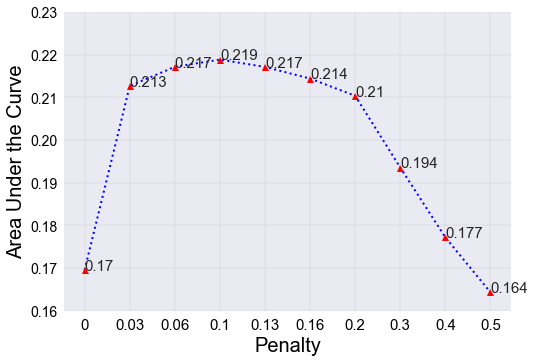

In [7]:
from scipy.integrate import simps
alist = []
for i in range(0, 0+num_plots):
    area = simps(tt[i,0:150]-tt2[i,0:150], dx=0.01)
    alist.append(area)
    print r'pen%1.2f area = %1.3f'% (penlist[i], area)

plt.figure(6)
fig,ax = plt.subplots(1)
ax.plot(alist,c='b',linewidth=2, linestyle=':')
for i,j in zip((0,1,2,3,4,5,6,7,8,9),alist):
    ax.annotate(str(round(j,3)),xy=(i,j), fontsize=15)
plt.plot(alist, 'r^')
plt.ylabel('Area Under the Curve', {'color': 'k', 'fontsize': 20})
plt.xlabel('Penalty', {'color': 'k', 'fontsize': 20})
plt.yticks(color='k',size=14)
plt.xticks((0,1,2,3,4,5,6,7,8,9),(penlist),color='k',size=15)
plt.ylim(0.16,0.23)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig("/Users/linan/Desktop/parameter_auc.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

In [32]:
stats.ttest_ind(tt[4,0:150],tt[0,0:150])

Ttest_indResult(statistic=-1.2235197992952322, pvalue=0.22209999744742945)

In [55]:
###Define a function to caculate the ChIP-seq signal in each bin of corresponding Hi-C matrix######
def computeMatrix(bedfile,boundarylist,chrn,winsize,res,chrs_l,tabfile):
    blist = boundarylist[(boundarylist>winsize)&(boundarylist<(chrs_l-winsize*res)/res)].astype(int)
    mm = np.zeros((len(blist),2*winsize+1))
    chrinfo = tabfile.loc[bedfile[0]==chrn]
    for i in range(0,len(blist)):
        mm[i,:]=chrinfo.iloc[blist[i]-winsize:blist[i]+winsize+1,4].values
    return mm

In [54]:
###chr length based on hg19; all ChIP-seq datasets are derived from ENCODE & Roadmap data portal#####
###bedfiles and tabfiles are generated by the bigWigAverageOverBed program from ENCODE#####
chrs_length = [249250621,243199373,198022430,191154276,180915260,171115067,159138663,146364022,141213431,135534747,135006516,133851895,115169878,107349540,102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566]
res = 10000
bedf = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/data/E116-Ctcf.fc.signal.bigwig.10kb.bed'),sep='\t',header=None)
tabf = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/data/E116-Ctcf.fc.signal.bigwig.10kb.tab'),sep='\t',header=None)

In [94]:
def getEnrichment(pen):
    cOnTAD_rawball = np.empty((0,21))
    for chrnum in range(1,22):
        OnTAD_raw = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTADraw_pen'+str(pen)+'_max200_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_rawa = OnTAD_raw.loc[(OnTAD_raw[2]>0),:].values[:,0:2]-1
        OnTAD_rawb = np.unique(OnTAD_rawa.flatten())
        cOnTAD_rawball = np.append(cOnTAD_rawball,computeMatrix(bedf,OnTAD_rawb,'chr'+str(chrnum),10,10000,chrs_length[chrnum-1],tabf), axis=0)
    return np.mean(cOnTAD_rawball, axis=0)

def getEnrichment2(hsz):
    cOnTAD_rawball = np.empty((0,21))
    for chrnum in range(1,22):
        OnTAD_raw = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_KRnorm_pen0.1_max200_hsz'+str(hsz)+'_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_rawa = OnTAD_raw.loc[(OnTAD_raw[2]>0),:].values[:,0:2]-1
        OnTAD_rawb = np.unique(OnTAD_rawa.flatten())
        cOnTAD_rawball = np.append(cOnTAD_rawball,computeMatrix(bedf,OnTAD_rawb,'chr'+str(chrnum),10,10000,chrs_length[chrnum-1],tabf), axis=0)
    return np.mean(cOnTAD_rawball, axis=0)

In [96]:
def compute_jaccard_index(set_1, set_2, offset):
    if offset == 0:
        n = len(np.intersect1d(set_1,set_2))
    else:
        set_1_offset=np.copy(set_1)
        for i in range(0,offset):
            set_1_offset = np.union1d(np.union1d(set_1_offset,set_1_offset - 1),set_1_offset + 1)
        n = len(np.intersect1d(set_1_offset,set_2))
    return n / float(len(np.union1d(set_1,set_2)))
def TADtoCluster (tads, chrbinlen, maxdist):
    tmat = np.zeros((chrbinlen,chrbinlen))
    ftads = tads[(tads[:,1]-tads[:,0]).argsort()[::-1],:].astype(int)
    a = []
    for i in range(0,ftads.shape[0]):
        tmat[ftads[i,0]:ftads[i,1],ftads[i,0]:ftads[i,1]] = i
    for offset in range(0,min(maxdist,chrbinlen-1)):
        ta= [row[rown+offset] for rown,row in enumerate(tmat) if rown+offset < len(row)]
        a+=ta
    return np.asarray(a)
def hszjarrand (hsz1, hsz2):
    OnTAD_rawrep1 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_KRnorm_pen0.1_max200_hsz'+str(hsz1)+'_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_rawrep1a = OnTAD_rawrep1.loc[(OnTAD_rawrep1[2]>0),:].values[:,0:2]-1
    OnTAD_rawrep1b = np.unique(OnTAD_rawrep1a.flatten())
    OnTAD_rep1t = TADtoCluster(OnTAD_rawrep1a, chrs_length[chrnum-1]/res, 200)
    OnTAD_rawrep2 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_KRnorm_pen0.1_max200_hsz'+str(hsz2)+'_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_rawrep2a = OnTAD_rawrep2.loc[(OnTAD_rawrep2[2]>0),:].values[:,0:2]-1
    OnTAD_rawrep2b = np.unique(OnTAD_rawrep2a.flatten())
    OnTAD_rep2t = TADtoCluster(OnTAD_rawrep2a, chrs_length[chrnum-1]/res, 200)
    return(compute_jaccard_index(OnTAD_rawrep1b,OnTAD_rawrep2b,0), adjusted_rand_score(OnTAD_rep1t, OnTAD_rep2t))

In [97]:
OnTAD_jar56 = []
OnTAD_rand56 = []
OnTAD_jar57 = []
OnTAD_rand57 = []
OnTAD_jar58 = []
OnTAD_rand58 = []
OnTAD_jar59 = []
OnTAD_rand59 = []
OnTAD_jar510 = []
OnTAD_rand510 = []

for chrnum in range(1,23):
    b56 = hszjarrand(5,6)
    OnTAD_jar56.append(b56[0])
    OnTAD_rand56.append(b56[1])
    b57 = hszjarrand(5,7)
    OnTAD_jar57.append(b57[0])
    OnTAD_rand57.append(b57[1])
    b58 = hszjarrand(5,8)
    OnTAD_jar58.append(b58[0])
    OnTAD_rand58.append(b58[1])
    b59 = hszjarrand(5,9)
    OnTAD_jar59.append(b59[0])
    OnTAD_rand59.append(b59[1])
    b510 = hszjarrand(5,10)
    OnTAD_jar510.append(b510[0])
    OnTAD_rand510.append(b510[1])

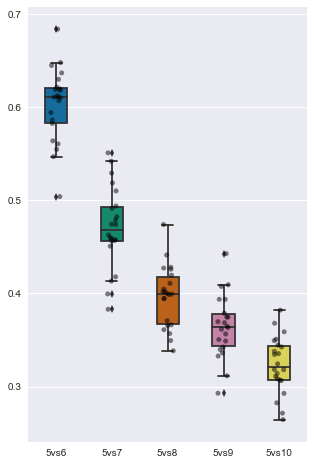

In [98]:
jartable = pandas.DataFrame({'5vs6':OnTAD_jar56, '5vs7':OnTAD_jar57, '5vs8': OnTAD_jar58,'5vs9':OnTAD_jar59, '5vs10':OnTAD_jar510})
plt.figure(1,figsize=(5,8))
sns.boxplot(data=jartable, width=0.4, palette="colorblind" ,order=["5vs6", '5vs7', '5vs8', '5vs9', '5vs10'])
sns.stripplot(data=jartable,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["5vs6", '5vs7', '5vs8', '5vs9', '5vs10'])
plt.show()

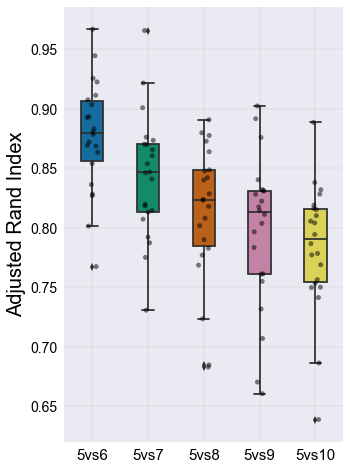

In [114]:
randtable = pandas.DataFrame({'5vs6':OnTAD_rand56, '5vs7':OnTAD_rand57, '5vs8': OnTAD_rand58,'5vs9':OnTAD_rand59, '5vs10':OnTAD_rand510})
plt.figure(1,figsize=(5,8))
sns.boxplot(data=randtable, width=0.4, palette="colorblind",order=["5vs6", '5vs7', '5vs8', '5vs9', '5vs10'])
sns.stripplot(data=randtable,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["5vs6", '5vs7', '5vs8', '5vs9', '5vs10'])
plt.yticks(color='k',size=14)
plt.xticks(color='k',size=15)
plt.ylabel('Adjusted Rand Index', {'color': 'k', 'fontsize': 20})
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig("/Users/linan/Desktop/hsz_randindex.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

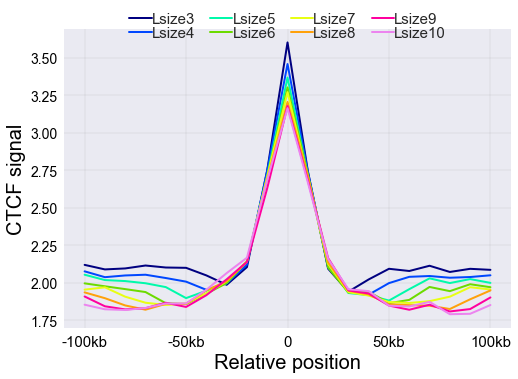

In [110]:
plt.figure(6)
num_plots = 8
hszlist = [3,4,5,6,7,8,9,10]

colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

x = np.arange(10)
labels = []
for i in range(0, num_plots):
    plt.plot(getEnrichment2(hszlist[i]),linewidth=2)
    labels.append(r'Lsize%d' % (hszlist[i]))

plt.legend(labels, ncol=4, loc='upper center', 
           bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True, fontsize=15)
plt.ylabel('CTCF signal', {'color': 'k', 'fontsize': 20})
plt.xlabel('Relative position', {'color': 'k', 'fontsize': 20})
plt.yticks(color='k',size=14)
plt.xticks((0,5,10,15,20),('-100kb','-50kb','0','50kb','100kb'),color='k',size=15)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig("/Users/linan/Desktop/hsz_ctcf.png", dpi=150, transparent=True)
plt.show()

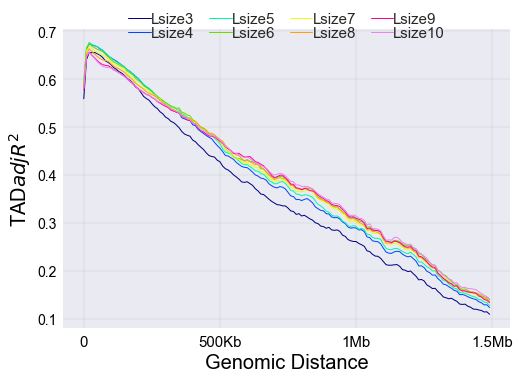

In [108]:
num_plots = 8
hszlist = [3,4,5,6,7,8,9,10]
thsz = np.loadtxt('/Users/linan/Downloads/testadjr2diffhsz_KRnorm.txt')

colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

x = np.arange(10)
labels = []
for i in range(0, 0+num_plots):
    plt.plot(thsz[i,0:150],linewidth=1)
    labels.append(r'Lsize%1d' % (hszlist[i]))

plt.legend(labels, ncol=4, loc='upper center', 
           bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True, fontsize=15)
#plt.xscale('log')
plt.ylabel('TAD$adjR^2$', {'color': 'k', 'fontsize': 20})
plt.xlabel('Genomic Distance', {'color': 'k', 'fontsize': 20})
plt.yticks(color='k',size=14)
plt.xticks((0,50,100,150),('0','500Kb','1Mb','1.5Mb'),color='k',size=15)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig("/Users/linan/Desktop/hsz_tadrsquared.png", dpi=150, transparent=True)
plt.show()

pen3.00 area = 264.760
pen4.00 area = 284.912
pen5.00 area = 289.118
pen6.00 area = 295.333
pen7.00 area = 291.574
pen8.00 area = 292.751
pen9.00 area = 292.308
pen10.00 area = 294.516


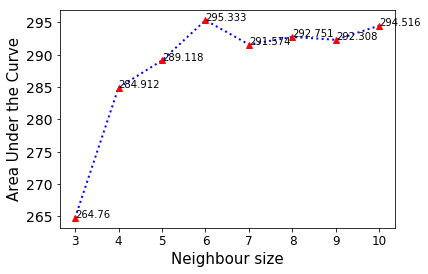

In [66]:
from scipy.integrate import simps
alist = []
for i in range(0, 0+num_plots):
    area = simps(thsz[i,0:150], dx=5)
    alist.append(area)
    print r'pen%1.2f area = %1.3f'% (hszlist[i], area)

plt.figure(6)
fig,ax = plt.subplots(1)
ax.plot(alist,c='b',linewidth=2, linestyle=':')
for i,j in zip((0,1,2,3,4,5,6,7,8,9),alist):
    ax.annotate(str(round(j,3)),xy=(i,j))
plt.plot(alist, 'r^')
plt.ylabel('Area Under the Curve', {'color': 'k', 'fontsize': 15})
plt.xlabel('Neighbour size', {'color': 'k', 'fontsize': 15})
plt.yticks(color='k',size=14)
plt.xticks((0,1,2,3,4,5,6,7),(hszlist),color='k',size=12)
plt.show()

In [10]:
def compareTWOpenEnrichment(pen1,pen2):
    cTADb = np.empty((0,21))
    n1 =0
    n2 = 0
    n3 = 0
    for chrnum in range(1,22):
        TAD1 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTADraw_pen'+str(pen1)+'_max200_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        TAD1a = TAD1.loc[(TAD1[2]>0),:].values[:,0:2]-1
        TAD1b = np.unique(TAD1a.flatten())
        TAD2 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTADraw_pen'+str(pen2)+'_max200_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        TAD2a = TAD2.loc[(TAD2[2]>0),:].values[:,0:2]-1
        TAD2b = np.unique(TAD2a.flatten())
        TADintersect = np.intersect1d(TAD1b,TAD2b)
        TAD1unique = np.setdiff1d(TAD1b,TAD2b)
        n1+=len(TAD1b)
        n2+=len(TAD2b)
        n3+=len(TAD1unique)
        cTADb = np.append(cTADb,computeMatrix(bedf,TAD1unique,'chr'+str(chrnum),10,10000,chrs_length[chrnum-1],tabf), axis=0)
    return np.mean(cTADb, axis=0)

In [17]:
compareTWOpenEnrichment(0.3,0.4)

array([ 2.1423029 ,  1.95065505,  1.96917821,  1.94120566,  1.93971619,
        1.81936667,  1.85466805,  1.91579172,  2.12339572,  2.30766885,
        2.88361649,  2.24332658,  2.04568504,  1.93069419,  1.88066391,
        1.8203565 ,  1.90508606,  2.04334248,  2.01986267,  1.9488565 ,
        1.9731451 ])